In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jr

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from ssm_jax.nlgssm.demos.simulations import PendulumSimulation
from ssm_jax.smc.inference import smc

In [3]:
sim = PendulumSimulation()

In [4]:
states, emissions, time_points = sim.sample(jr.PRNGKey(0))

Text(0.5, 0, 'time')

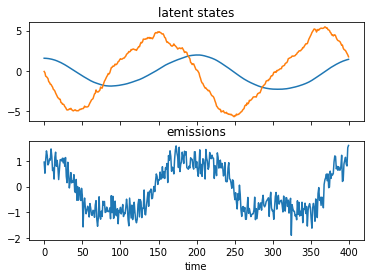

In [5]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(states)
axs[0].set_title("latent states")
axs[1].plot(emissions)
axs[1].set_title("emissions")
axs[1].set_xlabel("time")

In [6]:
# Make distribution functions like in SSM objects
def initial_distribution():
    return tfd.MultivariateNormalDiag(sim.initial_state, 0.01 * jnp.ones(2))

def transition_distribution(state):
    return tfd.MultivariateNormalFullCovariance(
        sim.dynamics_function(state), sim.dynamics_covariance)

def transition_distribution(state):
    return tfd.MultivariateNormalFullCovariance(
        sim.dynamics_function(state), sim.dynamics_covariance)

def emission_distribution(state):
    return tfd.MultivariateNormalFullCovariance(
        sim.emission_function(state), sim.emission_covariance)

In [7]:
def proposal_distribution(state, emission):
    return tfd.MultivariateNormalFullCovariance(
        sim.dynamics_function(state), sim.dynamics_covariance)

In [8]:
posterior = smc(jr.PRNGKey(0),
                initial_distribution,
                transition_distribution,
                emission_distribution,
                proposal_distribution,
                emissions,
                num_particles=100)

In [9]:
posterior.marginal_loglik

DeviceArray(-100.20963, dtype=float32)

In [10]:
from ssm_jax.smc.inference import reconstruct_particle_trajectories
trajectories = reconstruct_particle_trajectories(posterior)

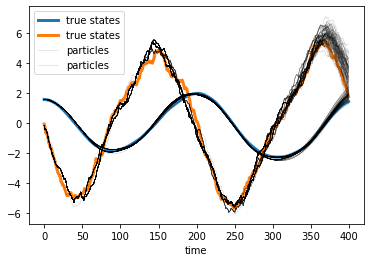

In [13]:
plt.plot(states, '-', lw=3, label="true states")

for i in range(100):
    plt.plot(trajectories[:, i, :], '-k', lw=0.5, alpha=0.2,
             label="particles" if i == 0 else None)
    
plt.xlabel("time")
plt.legend()